# Probelm Set 4 - Dynasties

The story of the problem goes: There are identical agents with infinite lifes maximizing (the infinite stream) of utility by chosing consumption, leisure (labor) and capital holdings. In period $T = 100$ there is a productivity shock and the economy transitions subsequently to the new steady state. Transition is assumed to be reached after 100 periods. We are interested in a) the new steady-state of the economy and b) the transition path.

Setting up the Lagrangian of this problem and deriving the 4 FOC yields optimality conditions that need to hold at all times in all states. Using variational analysis (or whatever) we can derive the steady-state conditions. My intuitivion then is as follows:
- First the initial st-st (before the productivity shock - point A) and the st-st after the shock (point B) pin down the levels: The economy has somehow to take itself from point A to point B.
- The "dynamic" laws, how the economy may move from A to B is characterised by the FOCs.
- Impose that after 100 periods the new st-st is reached -> 4x100 equations in 4x100 unknowns.
- Use `root` in order to solve for the dynamic transition path...

#### Exercise

Solve for and plot the transition paths for c, l, k, and $\lambda$. Assume that the economy will reach the new steady state in a finite time, say 100 periods. Impose this condition in the terminal period by assuming that $l_{T+100} = l_{T+99}, c_{T+100} = c_{T+99}$ and $\lambda_{T+100} = \lambda_{T+99}$. The FOCs give us a set of 4x100 equations in 4x100 unknowns that describe the optimal path of consumption, capital, and labor supply. Solve the first order conditions using a nonlinear equation solver such as `root`.

#### Class for Steady-States

In [2]:
# First we define a class that implements the steady-states
class dynasties_st_st:
    
    def __init__(self,
                 δ = 0.1, 
                 θ = 1/3, 
                 A = 1,
                 k_y_ratio = 3,
                 k_long = 3, 
                 l_long = 1/3):
        self.δ, self.θ, self.A, self.k_y_ratio, self.k_long, self.l_long = δ, θ, A, k_y_ratio, k_long, l_long
        
    def alpha(self):
        "Calibrate alpha"
        nominator = 1 - self.δ * self.k_long
        denominator = ((1 - self.θ)/ self.l_long) - (1 - self.θ) + (1 - self.δ * self.k_long)
        return nominator / denominator
    
    def beta(self):
        "Calibrate beta"
        return 1 / (1 + self.θ / self.k_y_ratio - self.δ)
    
    def constants(self):
        "Some important constants for easier noation"
        G = ((1 - self.beta() * (1 - self.δ)) / (self.beta() * self.θ * (self.A**(1 - self.θ))))**(1 / (1 - self.θ))
        J = (1 - self.beta() * (1 - self.δ)) / (self.beta() * self.θ) - self.δ
        return {'G': G, 'J' : J}
    
    def steady_states(self):
        "Define steady-states"
        # Define parameters
        α = self.alpha()
        G = self.constants()['G']
        J = self.constants()['J']
        # capital
        k_st_st = ((1 - self.θ) * α * (J + self.δ)) / ((J * (1 - α) + (J + self.δ) * (1 - self.θ) * α) * G)
        # consumption
        c_st_st = J * k_st_st
        # labour
        l_st_st = G * k_st_st
        # shadow price
        λ_st_st =  α / c_st_st
        # output
        y_st_st = (self.A**(1 - self.θ)) * (k_st_st**(self.θ)) * (l_st_st**(1-self.θ))
        return {'k' : k_st_st, 'c' : c_st_st, 'l' : l_st_st, 'λ' : λ_st_st, 'y' : y_st_st}

#### Old Steady-States

In [3]:
dyn_old = dynasties_st_st()
st_st_old = dyn_old.steady_states()

#### New Steady-States
(not needed in actual computations)

In [4]:
# Update technology
dyn_new = dynasties_st_st(A = 1.1)
st_st_new = dyn_new.steady_states()

#### Vector of Initial Guesses
With help of steady-states

In [5]:
import numpy as np

α, β = dyn_old.alpha(), dyn_old.beta()
c, l, k, λ = st_st_old['c'], st_st_old['l'], st_st_old['k'], st_st_old['λ']

# Define vector of guesses
c_guess = np.repeat(c, 100)
l_guess = np.repeat(l, 100)
k_guess = np.repeat(k, 100)

λ_guess = []
for i in range(100):
    λ_guess.append(λ * β**(i))
λ_guess = np.array(λ_guess)

# Stack in vector
guess = np.concatenate((c_guess, l_guess, k_guess, λ_guess))

#### Define Transition Function

In [6]:
import numpy as np

# Next, we will spell out the four transition equations (compare with matlab script and L12)
# As k is a state variable it is a parameter of the problem! It is predetermined!
# Importantly, we will define the FOC as implicit functions.
def transition(guess, α, β, δ, θ, A, k_st_st, n_guess):
    """
    Defines the four transition equations (FOC) and evaluates them given the initial guess.
    guess has to be provided as a vector (not matrix)!
    """
    
    T = int(len(guess) / n_guess)
    
    # Unpack guess
    c_lag = guess[0:T]
    l_lag = guess[T:2*T]
    k_lead = guess[2*T:3*T]
    λ_lag = guess[3*T:4*T]
        
    # Define some variables, such as lag and lead vectors (also impose that transition is completed after 100 periods!)
    k_lag = np.concatenate(([k_st_st], k_lead[0:(T-1)]))
    l_lead = np.concatenate((l_lag[1:T], [l_lag[-1]]))
    λ_lead = np.concatenate((λ_lag[1:T], [β * λ_lag[-1]]))
    β_vec = []
    for i in range(T):
        β_vec.append(β**(i))
    β_vec = np.array(β_vec)
    
    # First order (= optimality, transversality) conditions
    foc1 = β_vec * α / c_lag - λ_lag
    foc2 = β_vec * (1 - α) / (1 - l_lag) - λ_lag * (1 - θ) * (A**(1 - θ)) * (k_lag**(θ)) * (l_lag**(-θ))
    foc3 = λ_lead * (θ * (A**(1 - θ)) * (k_lead**(θ - 1)) * (l_lead**(1 - θ)) + 1 - δ) - λ_lag
    foc4 = c_lag + k_lead - (A**(1 - θ)) * (k_lag**(θ)) * (l_lag**(1 - θ)) - (1 - δ) * k_lag
    
    # Combine
    optimality_conditions = np.concatenate((foc1, foc2, foc3, foc4))
    
    return optimality_conditions

#### Define Parameters

In [7]:
# Parameters: α, β, δ, θ, A, k_st_st, n_guess
δ, θ, A, n_guess = dyn_new.δ, dyn_new.θ, dyn_new.A, 4
params = (α, β, δ, θ, A, k, n_guess)

#### Solve

In [8]:
from scipy.optimize import root, fsolve

# Apply root: roots are returned in method x
roots = root(fun = transition, x0 = guess, args = params)
dynamics = roots.x
roots.success

True

#### Unpack and Plot

In [9]:
# Unpack
T = int(len(dynamics) / 4)
consumption = dynamics[0:T]
labour = dynamics[(T):(2*T)]
labour = np.concatenate(([st_st_old['l']], labour))
capital = dynamics[(2*T):(3*T)]
capital = np.concatenate(([k], capital[0:(T-1)]))
shadow_price = dynamics[(3*T):(4*T)]

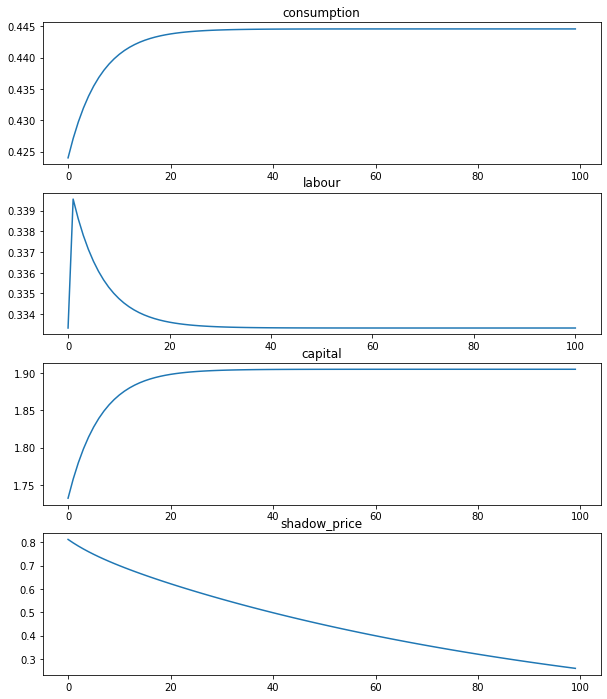

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline

num_rows, num_cols = 4, 1
fig, axes = plt.subplots(num_rows, num_cols, figsize=(10, 12))

axes[0].plot(consumption)
axes[0].set(title = 'consumption')
axes[1].plot(labour)
axes[1].set(title = 'labour')
axes[2].plot(capital)
axes[2].set(title = 'capital')
axes[3].plot(shadow_price)
axes[3].set(title = 'shadow_price')
plt.show()

In [11]:
st_st_old

{'k': 1.732050807568878,
 'c': 0.4041451884327379,
 'l': 0.3333333333333333,
 'λ': 0.8518282660174807,
 'y': 0.5773502691896258}

In [12]:
st_st_new

{'k': 1.9052558883257658,
 'c': 0.44455970727601163,
 'l': 0.33333333333333326,
 'λ': 0.7743893327431645,
 'y': 0.6350852961085882}